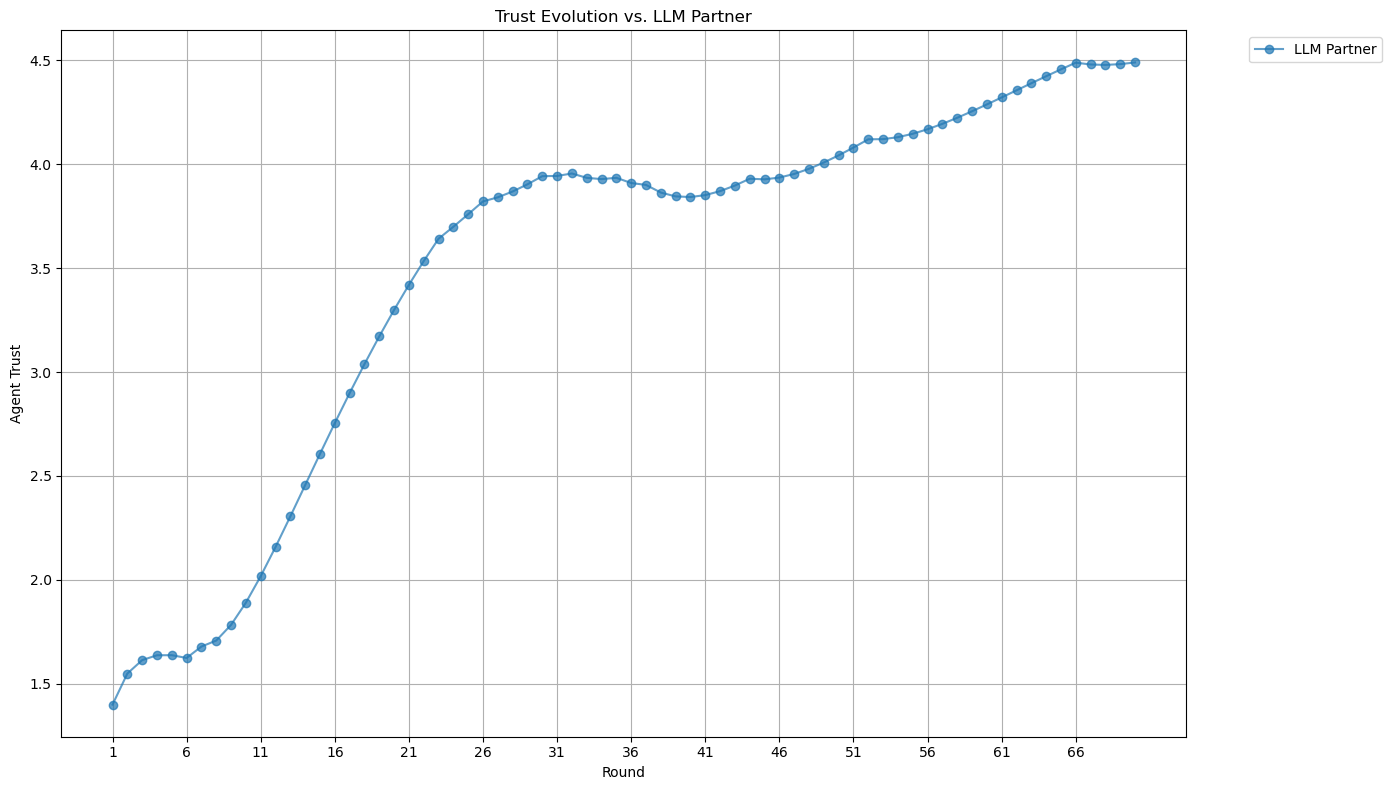

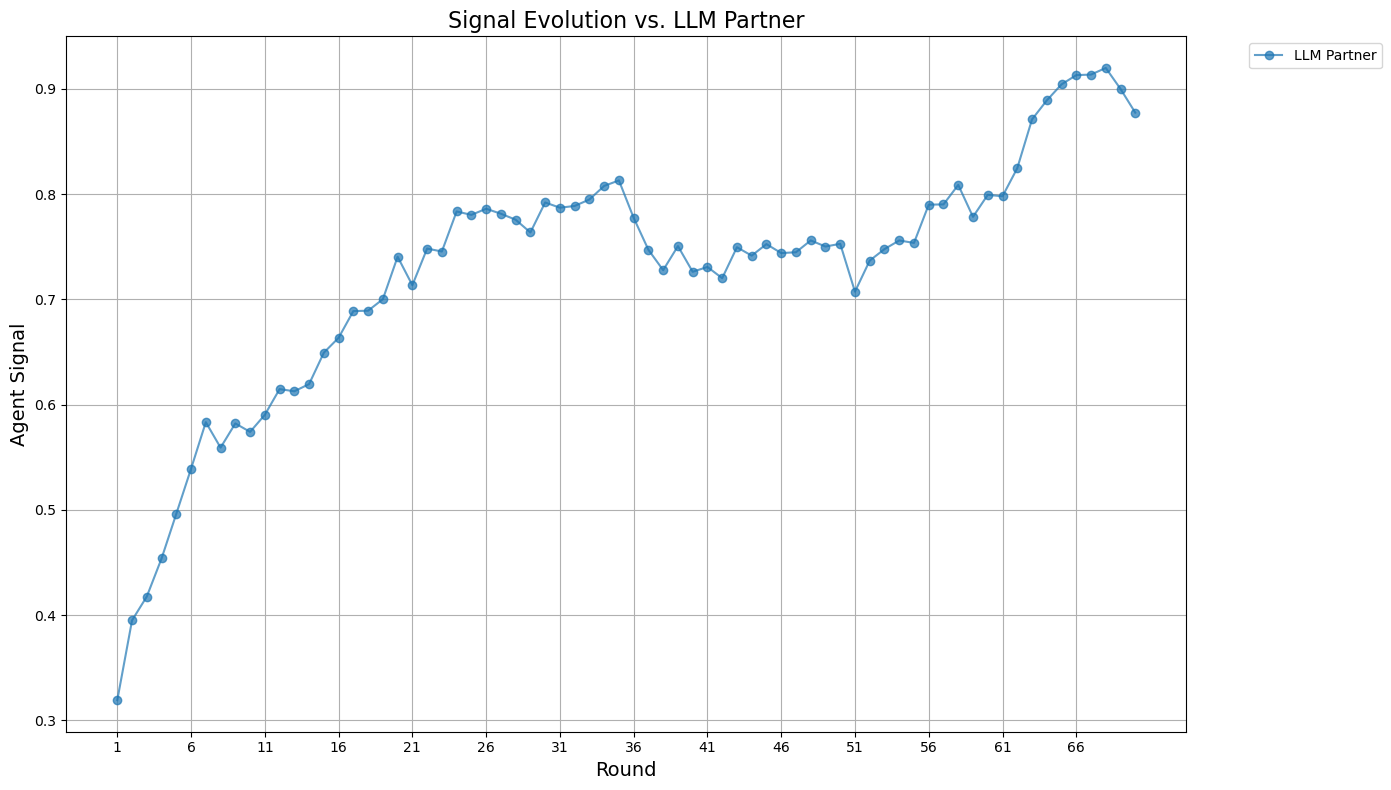

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

# === 1. Define payoff matrix ===
payoff = np.array([
    [[2, 2], [3, 0]],
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[player1_strategy, player2_strategy][player_id]

# === 2. LLM partner strategy using Ollama ===
def llm_partner_strategy(agent_history, partner_history, model_name='llama3.2'):
    prompt = (
        f"You are playing a Stag Hunt game.\n"
        f"Here is the history of moves over previous rounds:\n"
        f"- Your moves: {partner_history}\n"
        f"- Opponent's moves: {agent_history}\n\n"
        f"Based on this history, should you cooperate (1) or defect (0) in the next round?\n"
        f"Answer ONLY with one digit: 0 or 1."
    )
    try:
        process = subprocess.Popen(
            ['ollama', 'run', model_name],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        output, error = process.communicate(prompt, timeout=60)
        if process.returncode != 0:
            print(f"[LLM ERROR] Ollama returned an error:\n{error}")
            return 0
        output = output.strip()
        if '0' in output and '1' not in output:
            return 0
        elif '1' in output and '0' not in output:
            return 1
        else:
            print(f"[LLM WARNING] Ambiguous output: {output}. Defaulting to 0.")
            return 0
    except subprocess.TimeoutExpired:
        print("[LLM ERROR] Timeout when querying the model.")
        return 0
    except Exception as e:
        print(f"[LLM ERROR] {e}")
        return 0

# === 3. Trust-Signal Agent Class ===
class TrustSignalAgent:
    def __init__(self, u_i=None, t_init=1.0, eta=0.1, noise_sigma=0.02, discount_factor=0.9, trust_smoothing=0.1):
        self.x = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) /
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) +
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t = t_init
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.discount_factor = discount_factor
        self.trust_smoothing = trust_smoothing
        self.match_history = []

    def expected_p(self):
        return (1 + self.x * self.t) / (2 + self.t)

    def make_decision(self):
        p = self.expected_p()
        EV_hare = get_payoff(0, 0, 0) + p
        EV_stag = get_payoff(1, 1, 0) * p
        return 1 if EV_stag > EV_hare else 0

    def compute_new_trust(self, partner_choice):
        expected_choice = 1 if self.x > 0.5 else 0
        match = 1 if partner_choice == expected_choice else 0
        self.match_history.append(match)
        if not self.match_history:
            target_trust = 1.0
        else:
            weights = [self.discount_factor ** i for i in range(len(self.match_history)-1, -1, -1)]
            consistency = sum(m * w for m, w in zip(self.match_history, weights)) / sum(weights)
            target_trust = 1.0 + (5.0 - 1.0) * consistency
        new_trust = (1 - self.trust_smoothing) * self.t + self.trust_smoothing * target_trust
        return np.clip(new_trust, 0.1, 5.0)

    def compute_new_signal(self, P_obs):
        noise = np.random.normal(0, self.noise_sigma)
        return np.clip(self.x + self.eta * (P_obs - self.x) + noise, 0, 1)

    def update_state(self, new_trust, new_signal):
        self.t = new_trust
        self.x = new_signal

# === 4. Run simulation against LLM ===
def run_llm_simulation(num_rounds=70):
    agent = TrustSignalAgent()
    results = []
    agent_history = []
    partner_history = []

    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()
        partner_choice = llm_partner_strategy(agent_history, partner_history)

        agent_history.append(agent_choice)
        partner_history.append(partner_choice)

        # Compute observed cooperation frequency with discounting
        weights = [agent.discount_factor ** i for i in range(len(partner_history)-1, -1, -1)]
        P_obs = sum(p * w for p, w in zip(partner_history, weights)) / sum(weights)

        new_trust = agent.compute_new_trust(partner_choice)
        new_signal = agent.compute_new_signal(P_obs)
        agent.update_state(new_trust, new_signal)

        results.append((round_num + 1, agent_choice, partner_choice, agent.x, agent.t))

    return pd.DataFrame(results, columns=["Round", "Agent_Choice", "LLM_Choice", "Agent_Signal", "Agent_Trust"])

# === 5. Run and plot ===
if __name__ == "__main__":
    df = run_llm_simulation()

import seaborn as sns

# Define styling (even though we only plot one line now)
colors = sns.color_palette("tab10", 1)  # Just one color for LLM
line_styles = ['-']
markers = ['o']

# Visualize Trust Evolution
plt.figure(figsize=(14, 8))
plt.plot(df["Round"], df["Agent_Trust"], label="LLM Partner", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)

plt.xlabel("Round")
plt.ylabel("Agent Trust")
plt.title("Trust Evolution vs. LLM Partner")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xticks(ticks=np.arange(1, len(df["Round"]) + 1, step=5))
plt.tight_layout()
plt.show()

# Visualize Signal Evolution
plt.figure(figsize=(14, 8))
plt.plot(df["Round"], df["Agent_Signal"], label="LLM Partner", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)

plt.xlabel("Round", fontsize=14)
plt.ylabel("Agent Signal", fontsize=14)
plt.title("Signal Evolution vs. LLM Partner", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xticks(ticks=np.arange(1, len(df["Round"]) + 1, step=5))
plt.tight_layout()
plt.show()


In [2]:
df.LLM_Choice


0     0
1     1
2     1
3     1
4     1
     ..
65    1
66    0
67    1
68    1
69    1
Name: LLM_Choice, Length: 70, dtype: int64

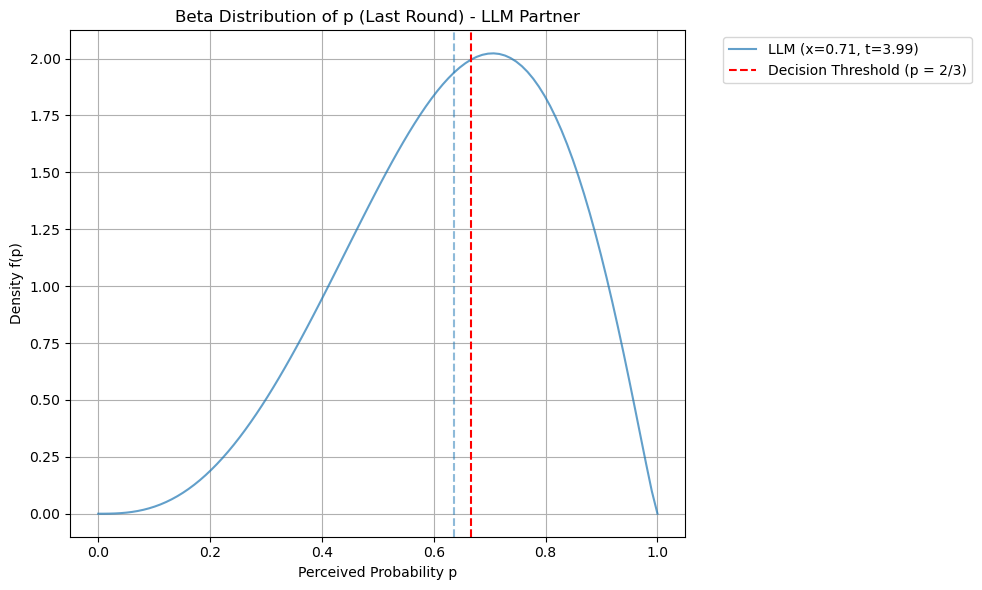

Decision-Making Summary in the Last Round:
LLM Partner: p = 0.637, Choice = Hare


In [14]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np

# Extract signal (x) and trust (t) from the last round
last_row = df.iloc[-1]
x = last_row["Agent_Signal"]
t = last_row["Agent_Trust"]

# Compute α, β, and E[p]
alpha = 1 + x * t
beta = 1 + (1 - x) * t
E_p = (1 + x * t) / (2 + t)

# Prepare range for plotting the Beta distribution
p = np.linspace(0, 1, 100)

# Plot the Beta distribution
plt.figure(figsize=(10, 6))
color = sns.color_palette("tab10")[0]

plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"LLM (x={x:.2f}, t={t:.2f})", color=color, alpha=0.7)
plt.axvline(x=E_p, color=color, linestyle='--', alpha=0.5)

# Add the decision threshold line
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

# Final plot settings
plt.xlabel("Perceived Probability p")
plt.ylabel("Density f(p)")
plt.title("Beta Distribution of p (Last Round) - LLM Partner")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Print decision summary
last_choice = last_row["Agent_Choice"]
print("Decision-Making Summary in the Last Round:")
print(f"LLM Partner: p = {E_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")


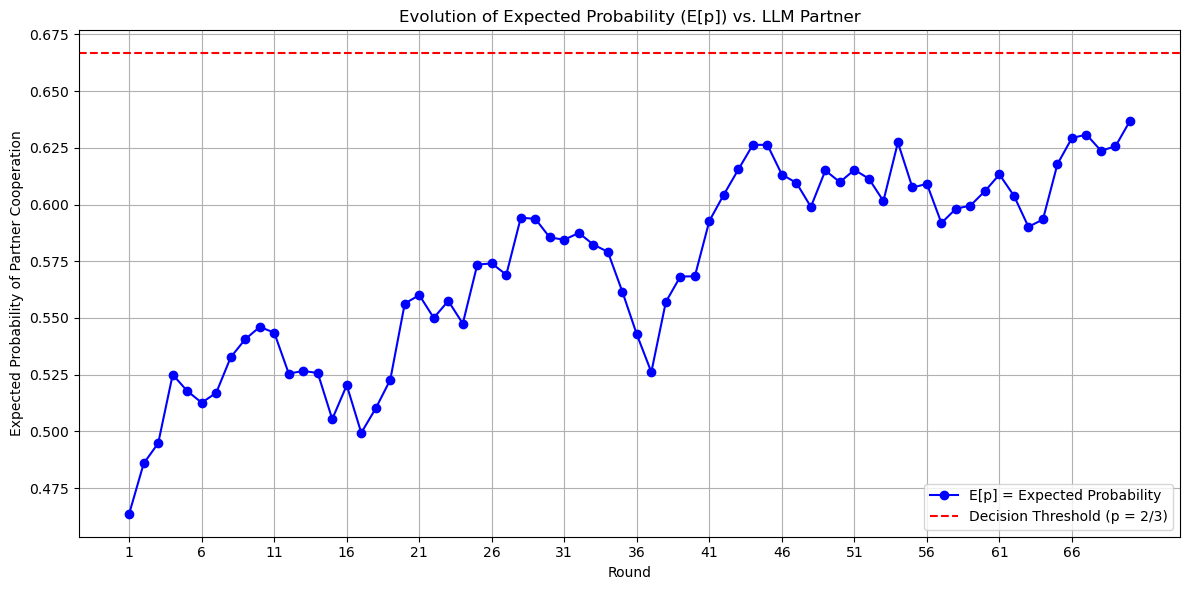

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Compute E[p] = (1 + x * t) / (2 + t) for each round
df["Expected_p"] = (1 + df["Agent_Signal"] * df["Agent_Trust"]) / (2 + df["Agent_Trust"])

# Plot Expected Probability Over Time
plt.figure(figsize=(12, 6))
plt.plot(df["Round"], df["Expected_p"], label="E[p] = Expected Probability", color="blue", marker="o")
plt.axhline(y=2/3, color="red", linestyle="--", label="Decision Threshold (p = 2/3)")

plt.xlabel("Round")
plt.ylabel("Expected Probability of Partner Cooperation")
plt.title("Evolution of Expected Probability (E[p]) vs. LLM Partner")
plt.grid(True)
plt.legend(loc="lower right")
plt.xticks(ticks=np.arange(1, len(df["Round"])+1, step=5))
plt.tight_layout()
plt.show()
